### Check GPU

In [1]:
pip install --upgrade jupyterhub

  Created wheel for python-json-logger: filename=python_json_logger-2.0.1-py34-none-any.whl size=7374 sha256=e55197aa94d3f18fb512110dd930de67ccd82c9f14d906b99be9535539927f4c
  Stored in directory: c:\users\trang\appdata\local\pip\cache\wheels\23\dd\19\e4d469fda8630bd61842b747618daa93bc332131e5e6851154
Successfully built python-json-logger
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade --user nbconvert

Note: you may need to restart the kernel to use updated packages.


ERROR: spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from tqdm.notebook import tqdm


In [ ]:
from tensorboard import version; print(version.VERSION)

2.4.1


In [ ]:
# check GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset and dataloader

In [ ]:
PATH = '/content/drive/MyDrive/'


- resize all the images to a size of 32x32
- convert them to single-channel images

Dataset.getitem() should return:
- two 32x32, single-channel images
- one target label

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, info_file, index_file, image_dir, transform=None):
        self.info_df = pd.read_csv(info_file)  
        self.index_df = pd.read_csv(index_file, sep=',',header =None,names=['index','source'])
        #self.classes = np.array(self.info_df.columns[1:]) # image labels 
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_index1 = self.info_df.iloc[idx, 0]
        img_name1 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index1-1, 1])[5:])
        image1 = Image.open(img_name1)
        image1 = image1.convert('L')
        
        img_index2 = self.info_df.iloc[idx, 1]
        img_name2 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index2-1, 1])[5:])
        image2 = Image.open(img_name2)
        image2 = image2.convert('L')
        
        label = self.info_df.iloc[idx, 2]
        
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1, image2, label

    def __len__(self):
        return len(self.info_df)

Check dataset

In [ ]:
RandomHorizontalFlip = transforms.Compose([transforms.RandomHorizontalFlip(p=0.9)]) 
ColorJitter = transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5)])  # [max(0, 1 - brightness), 1 + brightness] #[-hue, hue]
RandomCrop = transforms.Compose([transforms.RandomCrop(size=100)]) 
RandomRotation = transforms.Compose([transforms.RandomRotation(degrees=(10, 90))]) 

# more transform functions can refer to https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     #transforms.RandomHorizontalFlip(p=0.5), # data augmentation by fliping 
     transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
     transforms.Normalize((0.5,), (0.5,))   # channel=（channel-mean）/std  -> [-1, 1]
     ])
    


# if the image has one channel (grayscale), normalise operation will be 
#transforms.Normalize((0.5, ), (0.5, ))

In [ ]:
dataset = ImageDataset(PATH + 'train.csv', PATH + 'index.txt',PATH, transform=transform)

Load image dataset

In [ ]:
train_set = ImageDataset(PATH + 'train.csv', PATH + 'index.txt', PATH, transform=transform)
valid_set = ImageDataset(PATH + 'valid.csv', PATH + 'index.txt', PATH, transform=transform)
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128,shuffle=False)


### Define Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self, aggregation_type):
        super(Net, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
            
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)  
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
            
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
            
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)
            
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU(inplace=True)
            
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU(inplace=True)
            
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 1)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU(inplace=True)
            
        self.avg = nn.AvgPool2d(kernel_size=16,stride=1)
            
        self.flatten = nn.Flatten()
            
        
        self.aggregation_type = aggregation_type
        if(self.aggregation_type=="concatenation"):
            self.fc1 = nn.Linear(1024,512) # concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            self.fc1 = nn.Linear(512,512) # absolute substraction
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512,1)

    def forward(self, image1, image2):
        
        image1 = self.relu1(self.bn1(self.conv1(image1)))
        image1 = self.relu2(self.bn2(self.conv2(image1)))
        image1 = self.maxPool(image1)
        image1 = self.relu3(self.bn3(self.conv3(image1)))
        image1 = self.relu4(self.bn4(self.conv4(image1)))
        image1 = self.relu5(self.bn5(self.conv5(image1)))
        image1 = self.relu6(self.bn6(self.conv6(image1)))
        image1 = self.avg(image1)
        image1 = self.flatten(image1)
        
        image2 = self.relu1(self.bn1(self.conv1(image2)))
        image2 = self.relu2(self.bn2(self.conv2(image2)))
        image2 = self.maxPool(image2)
        image2 = self.relu3(self.bn3(self.conv3(image2)))
        image2 = self.relu4(self.bn4(self.conv4(image2)))
        image2 = self.relu5(self.bn5(self.conv5(image2)))
        image2 = self.relu6(self.bn6(self.conv6(image2)))
        image2 = self.avg(image2)
        image2 = self.flatten(image2)
        
        if(self.aggregation_type=="concatenation"):
            h3 = torch.cat((image1,image2),1) #concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            h3 = torch.abs(torch.sub(image1, image2)) #absolute substraction

        output = F.relu(self.fc1(h3))
        output = self.drop_out(output)
        output = self.fc2(output)
        output = nn.Sigmoid()(output)
        #output = torch.reshape(output,(-1,))
        
        return output

#### Function count the total number of trainable parameters

When aggregation function is absolute difference

In [ ]:
!pip install torchsummaryX
from torchsummaryX import summary

model = Net('absolute_substraction').cuda()
summary(model, torch.zeros((128, 1, 32, 32)).cuda(), torch.zeros((128, 1, 32, 32)).cuda())


                 Kernel Shape        Output Shape    Params    Mult-Adds
Layer                                                                   
0_conv1         [1, 32, 3, 3]   [128, 32, 32, 32]     320.0     294.912k
1_bn1                    [32]   [128, 32, 32, 32]      64.0         32.0
2_relu1                     -   [128, 32, 32, 32]         -            -
3_conv2        [32, 32, 3, 3]   [128, 32, 32, 32]    9.248k    9.437184M
4_bn2                    [32]   [128, 32, 32, 32]      64.0         32.0
5_relu2                     -   [128, 32, 32, 32]         -            -
6_maxPool                   -   [128, 32, 16, 16]         -            -
7_conv3        [32, 64, 3, 3]   [128, 64, 16, 16]   18.496k    4.718592M
8_bn3                    [64]   [128, 64, 16, 16]     128.0         64.0
9_relu3                     -   [128, 64, 16, 16]         -            -
10_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]   73.856k   18.874368M
11_bn4                  [128]  [128, 128, 16, 16]  

Kernel Shape        Output Shape     Params    Mult-Adds
Layer                                                                    
0_conv1         [1, 32, 3, 3]   [128, 32, 32, 32]      320.0     294912.0
1_bn1                    [32]   [128, 32, 32, 32]       64.0         32.0
2_relu1                     -   [128, 32, 32, 32]        NaN          NaN
3_conv2        [32, 32, 3, 3]   [128, 32, 32, 32]     9248.0    9437184.0
4_bn2                    [32]   [128, 32, 32, 32]       64.0         32.0
5_relu2                     -   [128, 32, 32, 32]        NaN          NaN
6_maxPool                   -   [128, 32, 16, 16]        NaN          NaN
7_conv3        [32, 64, 3, 3]   [128, 64, 16, 16]    18496.0    4718592.0
8_bn3                    [64]   [128, 64, 16, 16]      128.0         64.0
9_relu3                     -   [128, 64, 16, 16]        NaN          NaN
10_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]    73856.0   18874368.0
11_bn4                  [128]  [128, 128, 16, 16]      256.0        128.0
12_relu4                    -  [128, 128, 16, 16]        NaN          NaN
13_conv5     [128, 256, 3, 3]  [128, 256, 16, 16]   295168.0   75497472.0
14_bn5                  [256]  [128, 256, 16, 16]      512.0        256.0
15_relu5                    -  [128, 256, 16, 16]        NaN          NaN
16_conv6     [256, 512, 3, 3]  [128, 512, 16, 16]  1180160.0  301989888.0
17_bn6                  [512]  [128, 512, 16, 16]     1024.0        512.0
18_relu6                    -  [128, 512, 16, 16]        NaN          NaN
19_avg                      -    [128, 512, 1, 1]        NaN          NaN
20_flatten                  -          [128, 512]        NaN          NaN
21_conv1        [1, 32, 3, 3]   [128, 32, 32, 32]        NaN     294912.0
22_bn1                   [32]   [128, 32, 32, 32]        NaN         32.0
23_relu1                    -   [128, 32, 32, 32]        NaN          NaN
24_conv2       [32, 32, 3, 3]   [128, 32, 32, 32]        NaN    9437184.0
25_bn2                   [32]   [128, 32, 32, 32]        NaN         32.0
26_relu2                    -   [128, 32, 32, 32]        NaN          NaN
27_maxPool                  -   [128, 32, 16, 16]        NaN          NaN
28_conv3       [32, 64, 3, 3]   [128, 64, 16, 16]        NaN    4718592.0
29_bn3                   [64]   [128, 64, 16, 16]        NaN         64.0
30_relu3                    -   [128, 64, 16, 16]        NaN          NaN
31_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]        NaN   18874368.0
32_bn4                  [128]  [128, 128, 16, 16]        NaN        128.0
33_relu4                    -  [128, 128, 16, 16]        NaN          NaN
34_conv5     [128, 256, 3, 3]  [128, 256, 16, 16]        NaN   75497472.0
35_bn5                  [256]  [128, 256, 16, 16]        NaN        256.0
36_relu5                    -  [128, 256, 16, 16]        NaN          NaN
37_conv6     [256, 512, 3, 3]  [128, 512, 16, 16]        NaN  301989888.0
38_bn6                  [512]  [128, 512, 16, 16]        NaN        512.0
39_relu6                    -  [128, 512, 16, 16]        NaN          NaN
40_avg                      -    [128, 512, 1, 1]        NaN          NaN
41_flatten                  -          [128, 512]        NaN          NaN
42_fc1             [512, 512]          [128, 512]   262656.0     262144.0
43_drop_out                 -          [128, 512]        NaN          NaN
44_fc2               [512, 1]            [128, 1]      513.0        512.0

When aggregation function is concatenation

In [ ]:

model = Net('concatenation').cuda()
summary(model, torch.zeros((128, 1, 32, 32)).cuda(), torch.zeros((128, 1, 32, 32)).cuda())


                 Kernel Shape        Output Shape    Params    Mult-Adds
Layer                                                                   
0_conv1         [1, 32, 3, 3]   [128, 32, 32, 32]     320.0     294.912k
1_bn1                    [32]   [128, 32, 32, 32]      64.0         32.0
2_relu1                     -   [128, 32, 32, 32]         -            -
3_conv2        [32, 32, 3, 3]   [128, 32, 32, 32]    9.248k    9.437184M
4_bn2                    [32]   [128, 32, 32, 32]      64.0         32.0
5_relu2                     -   [128, 32, 32, 32]         -            -
6_maxPool                   -   [128, 32, 16, 16]         -            -
7_conv3        [32, 64, 3, 3]   [128, 64, 16, 16]   18.496k    4.718592M
8_bn3                    [64]   [128, 64, 16, 16]     128.0         64.0
9_relu3                     -   [128, 64, 16, 16]         -            -
10_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]   73.856k   18.874368M
11_bn4                  [128]  [128, 128, 16, 16]  

Kernel Shape        Output Shape     Params    Mult-Adds
Layer                                                                    
0_conv1         [1, 32, 3, 3]   [128, 32, 32, 32]      320.0     294912.0
1_bn1                    [32]   [128, 32, 32, 32]       64.0         32.0
2_relu1                     -   [128, 32, 32, 32]        NaN          NaN
3_conv2        [32, 32, 3, 3]   [128, 32, 32, 32]     9248.0    9437184.0
4_bn2                    [32]   [128, 32, 32, 32]       64.0         32.0
5_relu2                     -   [128, 32, 32, 32]        NaN          NaN
6_maxPool                   -   [128, 32, 16, 16]        NaN          NaN
7_conv3        [32, 64, 3, 3]   [128, 64, 16, 16]    18496.0    4718592.0
8_bn3                    [64]   [128, 64, 16, 16]      128.0         64.0
9_relu3                     -   [128, 64, 16, 16]        NaN          NaN
10_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]    73856.0   18874368.0
11_bn4                  [128]  [128, 128, 16, 16]      256.0        128.0
12_relu4                    -  [128, 128, 16, 16]        NaN          NaN
13_conv5     [128, 256, 3, 3]  [128, 256, 16, 16]   295168.0   75497472.0
14_bn5                  [256]  [128, 256, 16, 16]      512.0        256.0
15_relu5                    -  [128, 256, 16, 16]        NaN          NaN
16_conv6     [256, 512, 3, 3]  [128, 512, 16, 16]  1180160.0  301989888.0
17_bn6                  [512]  [128, 512, 16, 16]     1024.0        512.0
18_relu6                    -  [128, 512, 16, 16]        NaN          NaN
19_avg                      -    [128, 512, 1, 1]        NaN          NaN
20_flatten                  -          [128, 512]        NaN          NaN
21_conv1        [1, 32, 3, 3]   [128, 32, 32, 32]        NaN     294912.0
22_bn1                   [32]   [128, 32, 32, 32]        NaN         32.0
23_relu1                    -   [128, 32, 32, 32]        NaN          NaN
24_conv2       [32, 32, 3, 3]   [128, 32, 32, 32]        NaN    9437184.0
25_bn2                   [32]   [128, 32, 32, 32]        NaN         32.0
26_relu2                    -   [128, 32, 32, 32]        NaN          NaN
27_maxPool                  -   [128, 32, 16, 16]        NaN          NaN
28_conv3       [32, 64, 3, 3]   [128, 64, 16, 16]        NaN    4718592.0
29_bn3                   [64]   [128, 64, 16, 16]        NaN         64.0
30_relu3                    -   [128, 64, 16, 16]        NaN          NaN
31_conv4      [64, 128, 3, 3]  [128, 128, 16, 16]        NaN   18874368.0
32_bn4                  [128]  [128, 128, 16, 16]        NaN        128.0
33_relu4                    -  [128, 128, 16, 16]        NaN          NaN
34_conv5     [128, 256, 3, 3]  [128, 256, 16, 16]        NaN   75497472.0
35_bn5                  [256]  [128, 256, 16, 16]        NaN        256.0
36_relu5                    -  [128, 256, 16, 16]        NaN          NaN
37_conv6     [256, 512, 3, 3]  [128, 512, 16, 16]        NaN  301989888.0
38_bn6                  [512]  [128, 512, 16, 16]        NaN        512.0
39_relu6                    -  [128, 512, 16, 16]        NaN          NaN
40_avg                      -    [128, 512, 1, 1]        NaN          NaN
41_flatten                  -          [128, 512]        NaN          NaN
42_fc1            [1024, 512]          [128, 512]   524800.0     524288.0
43_drop_out                 -          [128, 512]        NaN          NaN
44_fc2               [512, 1]            [128, 1]      513.0        512.0

### 4.2.3 Training and Validation

In [ ]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path #f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss

def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss,threshold, device, save_name):
    
    step_list = []
    training_loss_list = []
    valid_loss_list = []
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        print('Resume training')


    no_step = 0;
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        running_corrects = 0
        for input1,input2, labels in tqdm(train_loader):
            
            no_step +=1
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)
            
            labels = labels.unsqueeze(1)
            labels = labels.float()

            '''Training of the model'''
            # Forward pass
            outputs = net(input1, input2)
            
   

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss = loss.item()
            running_loss += loss.item()
            preds = torch.gt(outputs, threshold).float()                       
            running_corrects += torch.sum(preds == labels.data)            
            
            with torch.no_grad():
                net.eval()
                running_loss_valid = 0.0
                running_corrects_valid = 0
                for input1_valid,input2_valid, labels_valid in tqdm(valid_loader):
            
                    input1_valid = input1_valid.to(device)
                    input2_valid = input2_valid.to(device)
                    labels_valid = labels_valid.to(device)

                    labels_valid = labels_valid.unsqueeze(1)
                    labels_valid = labels_valid.float()

                    outputs_valid = net(input1_valid,input2_valid)
                    loss_valid = criterion(outputs_valid, labels_valid)

                    running_loss_valid += loss_valid.item()
                    preds_valid = torch.gt(outputs_valid, threshold).int()
                    running_corrects_valid += torch.sum(preds_valid == labels_valid.data.int())

                valid_loss = running_loss_valid / len(valid_loader)
                valid_acc = running_corrects_valid / float(len(valid_loader.dataset))
            
            if(no_step%10==0):
                step_list.append(no_step)
                training_loss_list.append(training_loss)
                valid_loss_list.append(valid_loss)
                
                print("step ",no_step," training loss: ",training_loss,", validation loss: ",valid_loss,"\n")
            

        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / float(len(train_loader.dataset))

        with torch.no_grad():
            net.eval()
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):
            
                input1 = input1.to(device)
                input2 = input2.to(device)
                labels = labels.to(device)
                
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                preds = torch.gt(outputs, threshold).int()
                running_corrects += torch.sum(preds == labels.data.int())

            valid_loss = running_loss / len(valid_loader)
            valid_acc = running_corrects / float(len(valid_loader.dataset))

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            save_checkpoint(save_name, net, optimizer, best_val_loss)
    
    plt.plot(step_list,training_loss_list,label="Training Loss")
    plt.plot(step_list,valid_loss_list,label="Validation Loss")
    plt.xlabel('Number of steps')
    # Set a title of the current axes.
    plt.title('Traning and Validation loss curves')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    print('Finished Training')


step  10  training loss:  0.6948666572570801 , validation loss:  0.6907432874043783 




step  20  training loss:  0.7025440335273743 , validation loss:  0.6895455916722616 




step  30  training loss:  0.6801095604896545 , validation loss:  0.681563268105189 




Epoch [1/20], Train Loss: 0.6915, Train Acc: 0.5145, Valid Loss: 0.6922,  Valid Acc: 0.5400
Model saved to cifar_net.pt



step  40  training loss:  0.7128711938858032 , validation loss:  0.6949548423290253 




step  50  training loss:  0.6942494511604309 , validation loss:  0.6796076397101084 




step  60  training loss:  0.6947434544563293 , validation loss:  0.6820093790690104 




step  70  training loss:  0.6826469898223877 , validation loss:  0.6795931855837504 




Epoch [2/20], Train Loss: 0.6873, Train Acc: 0.5476, Valid Loss: 0.6851,  Valid Acc: 0.5600
Model saved to cifar_net.pt



step  80  training loss:  0.6955588459968567 , validation loss:  0.6828951239585876 




step  90  training loss:  0.6779999136924744 , validation loss:  0.688795804977417 




step  100  training loss:  0.6796267032623291 , validation loss:  0.6779171129067739 




step  110  training loss:  0.6888605356216431 , validation loss:  0.6718518634637197 




Epoch [3/20], Train Loss: 0.6816, Train Acc: 0.5639, Valid Loss: 0.6779,  Valid Acc: 0.5829
Model saved to cifar_net.pt



step  120  training loss:  0.6646427512168884 , validation loss:  0.6770367622375488 




step  130  training loss:  0.6893998384475708 , validation loss:  0.6773034433523814 




step  140  training loss:  0.6509653925895691 , validation loss:  0.6550565958023071 




step  150  training loss:  0.6378686428070068 , validation loss:  0.6489855895439783 




Epoch [4/20], Train Loss: 0.6676, Train Acc: 0.5990, Valid Loss: 0.6283,  Valid Acc: 0.6571
Model saved to cifar_net.pt



step  160  training loss:  0.7028433680534363 , validation loss:  0.686147004365921 




step  170  training loss:  0.6131941080093384 , validation loss:  0.6254264414310455 




step  180  training loss:  0.5895785689353943 , validation loss:  0.6144533554712931 




step  190  training loss:  0.6051024198532104 , validation loss:  0.5781079332033793 




Epoch [5/20], Train Loss: 0.6252, Train Acc: 0.6461, Valid Loss: 0.5641,  Valid Acc: 0.6843
Model saved to cifar_net.pt



step  200  training loss:  0.5507469177246094 , validation loss:  0.5638582309087118 




step  210  training loss:  0.5478396415710449 , validation loss:  0.599606583515803 




step  220  training loss:  0.523928165435791 , validation loss:  0.5520174453655878 




step  230  training loss:  0.49601036310195923 , validation loss:  0.5473838696877161 




Epoch [6/20], Train Loss: 0.5692, Train Acc: 0.7065, Valid Loss: 0.5639,  Valid Acc: 0.7129
Model saved to cifar_net.pt



step  240  training loss:  0.5312255620956421 , validation loss:  0.5805571029583613 




step  250  training loss:  0.5577026605606079 , validation loss:  0.5920674502849579 




step  260  training loss:  0.48632481694221497 , validation loss:  0.5747972230116526 




step  270  training loss:  0.5356755256652832 , validation loss:  0.5299440224965414 




Epoch [7/20], Train Loss: 0.5738, Train Acc: 0.7116, Valid Loss: 0.5735,  Valid Acc: 0.7214



step  280  training loss:  0.4713812470436096 , validation loss:  0.5222123910983404 




step  290  training loss:  0.5333454012870789 , validation loss:  0.5096296717723211 




step  300  training loss:  0.5388842225074768 , validation loss:  0.5080133080482483 




step  310  training loss:  0.4803345203399658 , validation loss:  0.5248424609502157 




Epoch [8/20], Train Loss: 0.5128, Train Acc: 0.7541, Valid Loss: 0.5391,  Valid Acc: 0.7371
Model saved to cifar_net.pt



step  320  training loss:  0.5332350730895996 , validation loss:  0.5294514993826548 




step  330  training loss:  0.5085883736610413 , validation loss:  0.5216564536094666 




step  340  training loss:  0.39608460664749146 , validation loss:  0.5120908468961716 




step  350  training loss:  0.45634153485298157 , validation loss:  0.49108407894770306 




Epoch [9/20], Train Loss: 0.5127, Train Acc: 0.7655, Valid Loss: 0.4945,  Valid Acc: 0.7500
Model saved to cifar_net.pt



step  360  training loss:  0.5927298665046692 , validation loss:  0.527561272184054 




step  370  training loss:  0.4692537188529968 , validation loss:  0.4936313380797704 




step  380  training loss:  0.39261186122894287 , validation loss:  0.5110721538464228 




step  390  training loss:  0.4802124798297882 , validation loss:  0.5238867898782095 





Epoch [10/20], Train Loss: 0.4670, Train Acc: 0.7818, Valid Loss: 0.5239,  Valid Acc: 0.7600



step  400  training loss:  0.4586968421936035 , validation loss:  0.4892575244108836 




step  410  training loss:  0.45419296622276306 , validation loss:  0.5175094256798426 




step  420  training loss:  0.5278504490852356 , validation loss:  0.4944668710231781 




Epoch [11/20], Train Loss: 0.4699, Train Acc: 0.7771, Valid Loss: 0.4855,  Valid Acc: 0.7429
Model saved to cifar_net.pt



step  430  training loss:  0.6866171360015869 , validation loss:  0.5003608415524164 




step  440  training loss:  0.3703399896621704 , validation loss:  0.48472067217032117 




step  450  training loss:  0.42924976348876953 , validation loss:  0.47311894595623016 




step  460  training loss:  0.3761714994907379 , validation loss:  0.4776137520869573 




Epoch [12/20], Train Loss: 0.4405, Train Acc: 0.7980, Valid Loss: 0.5120,  Valid Acc: 0.7586



step  470  training loss:  0.48447680473327637 , validation loss:  0.5319810758034388 




step  480  training loss:  0.38378727436065674 , validation loss:  0.5166976849238077 




step  490  training loss:  0.510421633720398 , validation loss:  0.48208657403786975 




step  500  training loss:  0.42210835218429565 , validation loss:  0.4584886133670807 




Epoch [13/20], Train Loss: 0.4385, Train Acc: 0.7986, Valid Loss: 0.5077,  Valid Acc: 0.7643



step  510  training loss:  0.41704994440078735 , validation loss:  0.4749466081460317 




step  520  training loss:  0.4635320007801056 , validation loss:  0.5117592712243398 




step  530  training loss:  0.3808099031448364 , validation loss:  0.47543932497501373 




step  540  training loss:  0.4154473841190338 , validation loss:  0.4970523416996002 




Epoch [14/20], Train Loss: 0.4330, Train Acc: 0.8059, Valid Loss: 0.4850,  Valid Acc: 0.7657
Model saved to cifar_net.pt



step  550  training loss:  0.43358445167541504 , validation loss:  0.5014012704292933 




step  560  training loss:  0.3977569341659546 , validation loss:  0.5005195389191309 




step  570  training loss:  0.32283568382263184 , validation loss:  0.47106007238229114 




step  580  training loss:  0.362640380859375 , validation loss:  0.46556756397088367 




Epoch [15/20], Train Loss: 0.4082, Train Acc: 0.8153, Valid Loss: 0.4474,  Valid Acc: 0.7971
Model saved to cifar_net.pt



step  590  training loss:  0.3468031585216522 , validation loss:  0.4662296225627263 




step  600  training loss:  0.40398359298706055 , validation loss:  0.46909969051678974 




step  610  training loss:  0.3994431495666504 , validation loss:  0.4753403216600418 




step  620  training loss:  0.4929797649383545 , validation loss:  0.48716093103090924 




Epoch [16/20], Train Loss: 0.3884, Train Acc: 0.8251, Valid Loss: 0.4557,  Valid Acc: 0.7729



step  630  training loss:  0.48038190603256226 , validation loss:  0.48880213499069214 




step  640  training loss:  0.2760363221168518 , validation loss:  0.461031973361969 




step  650  training loss:  0.39376771450042725 , validation loss:  0.47522084414958954 




step  660  training loss:  0.4251595735549927 , validation loss:  0.46893858909606934 




Epoch [17/20], Train Loss: 0.3774, Train Acc: 0.8284, Valid Loss: 0.4974,  Valid Acc: 0.7771



step  670  training loss:  0.36498159170150757 , validation loss:  0.4482742597659429 




step  680  training loss:  0.31845009326934814 , validation loss:  0.45322337249914807 




step  690  training loss:  0.39378753304481506 , validation loss:  0.46534330646197003 




step  700  training loss:  0.3796842694282532 , validation loss:  0.4675101588169734 




Epoch [18/20], Train Loss: 0.3683, Train Acc: 0.8343, Valid Loss: 0.4747,  Valid Acc: 0.7743



step  710  training loss:  0.3745124042034149 , validation loss:  0.44664745032787323 




step  720  training loss:  0.3493061065673828 , validation loss:  0.4816757341225942 




step  730  training loss:  0.4168303906917572 , validation loss:  0.5002507915099462 




step  740  training loss:  0.2920694351196289 , validation loss:  0.4783175190289815 




Epoch [19/20], Train Loss: 0.3491, Train Acc: 0.8467, Valid Loss: 0.4841,  Valid Acc: 0.7900



step  750  training loss:  0.3411478102207184 , validation loss:  0.4417131841182709 




step  760  training loss:  0.3437668979167938 , validation loss:  0.44946542382240295 




step  770  training loss:  0.33503323793411255 , validation loss:  0.4741028845310211 




step  780  training loss:  0.23453783988952637 , validation loss:  0.4851868152618408 





Epoch [20/20], Train Loss: 0.3239, Train Acc: 0.8604, Valid Loss: 0.4852,  Valid Acc: 0.7886


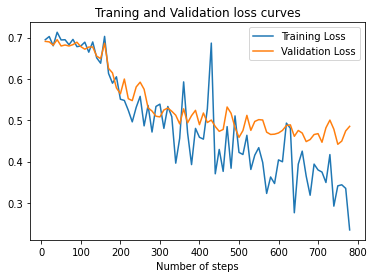

Finished Training


In [ ]:
model = Net("absolute_substraction").cuda()
num_epochs = 20
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
threshold = 0.5
save_path = f'cifar_net.pt'
model = model.to(device)


TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss,threshold, device, save_path)

### 4.2.4 Evaluation

In [ ]:
def eval(net, valid_loader):
    max_valid_acc = 0
    optimal_threshold = 0
    threshold_array = np.arange(0.0, 1.0, 0.02)
    for threshold in threshold_array:
        print(threshold)
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):

                input1 = input1.to(device)
                input2 = input2.to(device)

                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                preds = torch.gt(outputs, threshold).int()

                running_corrects += torch.sum(preds == labels.data)

            valid_acc = running_corrects / float(len(valid_loader.dataset))
            print("valid_acc: ", valid_acc)
            if(valid_acc > max_valid_acc):
                max_valid_acc = valid_acc
                optimal_threshold = threshold
    return max_valid_acc,optimal_threshold
                    

In [ ]:
max_valid_acc,optimal_threshold = eval(model, valid_loader)

0.0



valid_acc:  tensor(0.5000, device='cuda:0')
0.02



valid_acc:  tensor(0.6700, device='cuda:0')
0.04



valid_acc:  tensor(0.6986, device='cuda:0')
0.06



valid_acc:  tensor(0.7171, device='cuda:0')
0.08



valid_acc:  tensor(0.7257, device='cuda:0')
0.1



valid_acc:  tensor(0.7400, device='cuda:0')
0.12



valid_acc:  tensor(0.7414, device='cuda:0')
0.14



valid_acc:  tensor(0.7443, device='cuda:0')
0.16



valid_acc:  tensor(0.7486, device='cuda:0')
0.18



valid_acc:  tensor(0.7514, device='cuda:0')
0.2



valid_acc:  tensor(0.7557, device='cuda:0')
0.22



valid_acc:  tensor(0.7586, device='cuda:0')
0.24



valid_acc:  tensor(0.7586, device='cuda:0')
0.26



valid_acc:  tensor(0.7643, device='cuda:0')
0.28



valid_acc:  tensor(0.7643, device='cuda:0')
0.3



valid_acc:  tensor(0.7643, device='cuda:0')
0.32



valid_acc:  tensor(0.7643, device='cuda:0')
0.34



valid_acc:  tensor(0.7657, device='cuda:0')
0.36



valid_acc:  tensor(0.7671, device='cuda:0')
0.38



valid_acc:  tensor(0.7700, device='cuda:0')
0.4



valid_acc:  tensor(0.7686, device='cuda:0')
0.42



valid_acc:  tensor(0.7757, device='cuda:0')
0.44



valid_acc:  tensor(0.7757, device='cuda:0')
0.46



valid_acc:  tensor(0.7814, device='cuda:0')
0.48



valid_acc:  tensor(0.7843, device='cuda:0')
0.5



valid_acc:  tensor(0.7886, device='cuda:0')
0.52



valid_acc:  tensor(0.7957, device='cuda:0')
0.54



valid_acc:  tensor(0.7986, device='cuda:0')
0.56



valid_acc:  tensor(0.7957, device='cuda:0')
0.58



valid_acc:  tensor(0.7914, device='cuda:0')
0.6



valid_acc:  tensor(0.7929, device='cuda:0')
0.62



valid_acc:  tensor(0.7900, device='cuda:0')
0.64



valid_acc:  tensor(0.7886, device='cuda:0')
0.66



valid_acc:  tensor(0.7914, device='cuda:0')
0.68



valid_acc:  tensor(0.7943, device='cuda:0')
0.7000000000000001



valid_acc:  tensor(0.7943, device='cuda:0')
0.72



valid_acc:  tensor(0.7900, device='cuda:0')
0.74



valid_acc:  tensor(0.7929, device='cuda:0')
0.76



valid_acc:  tensor(0.7971, device='cuda:0')
0.78



valid_acc:  tensor(0.7871, device='cuda:0')
0.8



valid_acc:  tensor(0.7771, device='cuda:0')
0.8200000000000001



valid_acc:  tensor(0.7814, device='cuda:0')
0.84



valid_acc:  tensor(0.7643, device='cuda:0')
0.86



valid_acc:  tensor(0.7457, device='cuda:0')
0.88



valid_acc:  tensor(0.7214, device='cuda:0')
0.9



valid_acc:  tensor(0.6957, device='cuda:0')
0.92



valid_acc:  tensor(0.6729, device='cuda:0')
0.9400000000000001



valid_acc:  tensor(0.6200, device='cuda:0')
0.96



valid_acc:  tensor(0.5514, device='cuda:0')
0.98



valid_acc:  tensor(0.5071, device='cuda:0')


In [ ]:
print(max_valid_acc)

tensor(0.7986, device='cuda:0')


In [ ]:
print(optimal_threshold)

0.54


### Predict output

In [ ]:
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)
test_loader = DataLoader(test_set,
                         num_workers = 0,
                         batch_size=1,
                         shuffle=False)
test_df = pd.read_csv(PATH + 'test.csv')

In [ ]:
test_loaderRGB = DataLoader(test_set,
                         num_workers = 0,
                         batch_size=1,
                         shuffle=False)
test_df = pd.read_csv(PATH + 'test.csv')
predictions=[]
i = 0
with torch.no_grad():
    for input1,input2, label in tqdm(test_loaderRGB):
        input1 = input1.to(device)
        input2 = input2.to(device)

        outputs = model(input1,input2)
        preds = torch.gt(outputs, optimal_threshold).int()
    
        predictions.append(preds.cpu().numpy().ravel()[0])
        
test_df['target'] = predictions

test_df.to_csv("submission_original_model.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

id1   id2  target
0   4988  4973       0
1   4958  4939       0
2   4552  4891       0
3   4509  4504       1
4   4589  4587       1
5   4635  4634       1
6   4758  4751       1
7   4544  4543       1
8   4849  4887       1
9   4929  4926       0
10  4912  4918       1
11  4705  4708       1
12  4799  4864       0
13  4763  4767       1
14  4833  4839       1
15  4533  4637       0
16  4719  4712       0
17  4969  4967       0
18  4654  4921       0
19  4575  4582       1
20  4976  4975       0
21  4915  4943       0
22  4725  4985       0
23  4967  4961       1
24  4755  4754       1
25  4825  4890       0
26  4869  4725       1
27  4892  4891       1
28  4960  4951       1
29  4508  4729       0
30  4721  4723       1
31  4956  4556       0
32  4510  4502       1
33  4515  4512       1
34  4571  4578       1
35  4897  4754       0
36  4858  4853       0
37  4842  4556       0
38  4530  4523       1
39  4582  4970       1
40  4774  4565       0
41  4562  4986       0
42  4888  4882       0
43  4651  4659       1
44  4588  4583       1
45  4769  4711       0
46  4861  4870       1
47  4510  4507       1
48  4873  4871       1
49  4604  4601       1